In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ktaebum/anime-sketch-colorization-pair")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/anime-sketch-colorization-pair


In [2]:
import torch
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

## Configuration Class:
### Setting hyperparameters (according to the paper) and paths.

In [3]:
class Config:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LEARNING_RATE = 2e-4
    BATCH_SIZE = 16
    NUM_WORKERS = 2
    IMAGE_SIZE = 256
    NUM_EPOCHS = 100
    L1_LAMBDA = 100
    LOAD_MODEL = False
    SAVE_MODEL = True
    CHECKPOINT_DISC = "/content/disc.pth.tar"
    CHECKPOINT_GEN = "/content/gen.pth.tar"
    TRAIN_DIR = "/kaggle/input/anime-sketch-colorization-pair/data/train/"
    VAL_DIR = "/kaggle/input/anime-sketch-colorization-pair/data/val/"

config = Config()


## Data Augmentation:
* Resize and augment both input & target images similarly.
* Apply additional jittering to only input images (colorization task).
* Normalize and convert to tensors.

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

both_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),  #both input and corresponding output need to be flipped simultaneously
    ],
    additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.ColorJitter(p=0.2),  # Only affects input
        A.Normalize(mean=[0.5]*3, std=[0.5]*3, max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5]*3, std=[0.5]*3, max_pixel_value=255.0),
        ToTensorV2(),
    ]
)


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Dataset Class:
#### Loads paired anime sketch-color images; splits them into input and target halves(as both are present in the same image) and applies augmentations and returns tensor pairs.

In [5]:
class AnimeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.list_files = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))

        h, w, c = image.shape
        half_w = w // 2

        input_image = image[:, half_w:, :]
        target_image = image[:, :half_w, :]

        augmented = both_transform(image=input_image, image0=target_image)
        input_image = augmented["image"]
        target_image = augmented["image0"]

        if self.transform:
            input_image = self.transform(Image.fromarray(input_image))
            target_image = self.transform(Image.fromarray(target_image))
        else:
            input_image = transform_only_input(image=input_image)["image"]
            target_image = transform_only_mask(image=target_image)["image"]

        return input_image, target_image

### Wraps the dataset into a PyTorch DataLoader for efficient batching and shuffling during training.

In [6]:
train_dataset  = AnimeDataset("/kaggle/input/anime-sketch-colorization-pair/data/train/")
train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=2,
    )

## Visualizing Data:
#### Displays one pair of input and target images after preprocessing, to verify correctness of loading and augmentations.



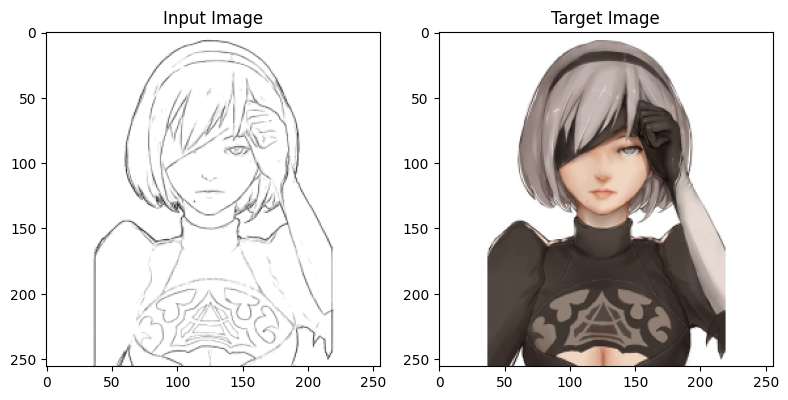

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

for i, (input_image, target_image) in enumerate(train_loader):
    if i == 1:
        break

def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Reverse normalization
    return tensor.clamp(0, 1)

# Plot input and target images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(denormalize(input_image[0]).permute(1, 2, 0).cpu().numpy())

plt.subplot(1, 2, 2)
plt.title("Target Image")
plt.imshow(denormalize(target_image[0]).permute(1, 2, 0).cpu().numpy())

plt.tight_layout()
plt.show()

## Discriminator Model:
#### Implements a PatchGAN-style discriminator that judges whether each local patch of the generated image looks realistic when paired with the input sketch.

In [8]:
class CNN_block_disc(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False, padding_mode="reflect"), #bias=False since batchnorm is used
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
         )

    def forward(self,x):
        return self.conv_layer(x)

class Discriminator(nn.Module):
    def __init__(self,in_channels=3):
        super().__init__()
        self.initial_layer=nn.Sequential(
            nn.Conv2d(in_channels*2, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )

        self.model = nn.Sequential(
            CNN_block_disc(64,128,stride=2),
            CNN_block_disc(128,128,stride=1),
            CNN_block_disc(128,256,stride=2),
            CNN_block_disc(256,512,stride=1),
            nn.Conv2d(512, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
        )

    def forward(self,x,y):
        x = torch.cat([x,y],dim=1) #colunn wise concatenation
        x = self.initial_layer(x)
        x = self.model(x)
        return x

## Generator Model (U-Net):
* #### U-Net architecture for high-resolution image generation.
* #### Encodes input sketches into latent features, then decodes them to reconstruct a colored image.
* #### Skip connections between encoder and decoder layers preserve spatial information.

In [9]:
class CNN_block_gen(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2, upscale=False, act="LeakyReLU", use_dropout=False):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,4,2,1, bias=False) if upscale
            else nn.Conv2d(in_channels,out_channels,4,stride,1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act=="relu" else nn.LeakyReLU(0.2)
         )
        self.use_dropout=use_dropout
        self.dropout=nn.Dropout(0.5)

    def forward(self,x):
        x = self.conv_layer(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self,in_channels=3, features=64):
        super().__init__()
        self.first=nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )

        self.down1 = CNN_block_gen(features, features*2, upscale=False, act="LeakyReLU", use_dropout=False)
        self.down2 = CNN_block_gen(features*2, features*4, upscale=False, act="LeakyReLU", use_dropout=False)
        self.down3 = CNN_block_gen(features*4, features*8, upscale=False, act="LeakyReLU", use_dropout=False)
        self.down4 = CNN_block_gen(features*8, features*8, upscale=False, act="LeakyReLU", use_dropout=False)
        self.down5 = CNN_block_gen(features*8, features*8, upscale=False, act="LeakyReLU", use_dropout=False)
        self.down6 = CNN_block_gen(features*8, features*8, upscale=False, act="LeakyReLU", use_dropout=False)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode="reflect"), nn.ReLU(),
        )

        self.up1 = CNN_block_gen(features*8, features*8, upscale=True, act="relu", use_dropout=True)
        self.up2 = CNN_block_gen(features*8*2, features*8, upscale=True, act="relu", use_dropout=True)
        self.up3 = CNN_block_gen(features*8*2, features*8, upscale=True, act="relu", use_dropout=False)
        self.up4 = CNN_block_gen(features*8*2, features*8, upscale=True, act="relu", use_dropout=False)
        self.up5 = CNN_block_gen(features*8*2, features*4, upscale=True, act="relu", use_dropout=False)
        self.up6 = CNN_block_gen(features*4*2, features*2, upscale=True, act="relu", use_dropout=False)
        self.up7 = CNN_block_gen(features*2*2, features, upscale=True, act="relu", use_dropout=False)
        self.last=nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels,kernel_size=4,stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.first(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)

        bottleneck = self.bottleneck(d7)

        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))

        return self.last(torch.cat([up7, d1], 1))


## Function for Losses vs epochs plot

#### Create a TensorBoard-style loss plot with multiple lines on one graph

In [10]:
def plot_tensorboard_style_losses(loss_history, save_path="training_losses.png"):

    epochs = range(1, len(loss_history['disc_loss']) + 1)

    plt.figure(figsize=(12, 8))
    plt.style.use('default')

    colors = {
        'gen_train': '#1f77b4',      # Blue
        'disc_train': '#ff7f0e',     # Orange
        'gen_test': '#2ca02c',       # Green
        'disc_test': '#d62728',      # Red
        'l1_test': '#9467bd'         # Purple
    }

    plt.plot(epochs, loss_history['gen_loss'], color=colors['gen_train'],
             linewidth=2, label='Generator Train Loss', alpha=0.8)
    plt.plot(epochs, loss_history['disc_loss'], color=colors['disc_train'],
             linewidth=2, label='Discriminator Train Loss', alpha=0.8)
    plt.plot(epochs, loss_history['l1_loss'], color=colors['l1_test'],
             linewidth=2, label='L1 Test Loss', alpha=0.8)

    plt.title('Training Losses', fontsize=16, fontweight='normal', pad=20)
    plt.xlabel('Checkpoint every 5 epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)

    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    plt.legend(loc='upper right', frameon=True, fancybox=False, shadow=False,
               fontsize=10, bbox_to_anchor=(1, 1))

    plt.xlim(0, max(epochs))
    plt.ylim(0, None)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()


## Training Function:
* #### Discriminator learns to distinguish real vs generated images.Generator learns to fool the discriminator and get close to real targets (via L1 loss).
* #### Uses mixed precision training (torch.cuda.amp) for speed and efficiency.

In [11]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)

    d_loss_total = 0.0
    g_loss_total = 0.0
    l1_loss_total = 0.0
    d_real_acc = 0.0
    d_fake_acc = 0.0
    num_batches = 0


    for idx, (x, y) in enumerate(loop):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss)

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * config.L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()


        # Accumulate losses for averaging
        d_loss_total += D_loss.item()
        g_loss_total += G_loss.item()
        l1_loss_total += L1.item()
        d_real_acc += torch.sigmoid(D_real).mean().item()
        d_fake_acc += torch.sigmoid(D_fake).mean().item()
        num_batches += 1

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
                G_loss=G_loss.item(),
                L1_loss=L1.item()
            )

    return {
        'disc_loss': d_loss_total / num_batches,
        'gen_loss': g_loss_total / num_batches,
        'l1_loss': l1_loss_total / num_batches,
        'disc_real_acc': d_real_acc / num_batches,
        'disc_fake_acc': d_fake_acc / num_batches
    }

## Checkpoint Utilities:
#### Essential for resuming training from saved checkpoints.

In [12]:
def save_some_examples(gen, val_loader, epoch, folder):
    os.makedirs(folder, exist_ok=True)

    x, y = next(iter(val_loader))
    x, y = x.to(config.DEVICE), y.to(config.DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # De-normalize
        save_image(y_fake, f"{folder}/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, f"{folder}/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, f"{folder}/label_{epoch}.png")
    gen.train()

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


## Model Initialization and Training loop:
1. #### Initializes models, optimizers, and loaders.
2. #### Runs the training loop across epochs.
3. #### Saves checkpoints and example outputs periodically.

In [ ]:
disc = Discriminator(in_channels=3).to(config.DEVICE)
gen = Generator(in_channels=3, features=64).to(config.DEVICE)
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()
if config.LOAD_MODEL:
    load_checkpoint(config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE)
    load_checkpoint(config.CHECKPOINT_DISC, disc, opt_disc, config.LEARNING_RATE)

val_dataset = AnimeDataset(root_dir=config.VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

loss_history = {
        'disc_loss': [],
        'gen_loss': [],
        'l1_loss': [],
        'disc_real_acc': [],
        'disc_fake_acc': []
    }

for epoch in range(config.NUM_EPOCHS):
    epoch_losses = train_fn(
            disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,
        )

      # Store losses in history
    loss_history['disc_loss'].append(epoch_losses['disc_loss'])
    loss_history['gen_loss'].append(epoch_losses['gen_loss'])
    loss_history['l1_loss'].append(epoch_losses['l1_loss'])
    loss_history['disc_real_acc'].append(epoch_losses['disc_real_acc'])
    loss_history['disc_fake_acc'].append(epoch_losses['disc_fake_acc'])

    if config.SAVE_MODEL and epoch % 5 == 0:
        save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=config.CHECKPOINT_DISC)

    save_some_examples(gen, val_loader, epoch, folder="evaluation")

print("\nTraining completed! Generating final TensorBoard-style loss plots...")
plot_tensorboard_style_losses(loss_history, "final_tensorboard_style_losses.png")


## Loading the data:
#### Initialize a new generator model and load its weights from a previously saved checkpoint.

In [14]:
new_gen = Generator(in_channels=3, features=64).to(config.DEVICE)
opt_gen = optim.Adam(new_gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
load_checkpoint(config.CHECKPOINT_GEN, new_gen, opt_gen, config.LEARNING_RATE)
new_gen.eval()

=> Loading checkpoint


Generator(
  (first): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): CNN_block_gen(
    (conv_layer): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): CNN_block_gen(
    (conv_layer): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): CNN_block_gen(
    (conv_layer): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2,

## Loading test dataset

In [16]:
test_dataset = AnimeDataset("/kaggle/input/anime-sketch-colorization-pair/data/val/")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


## Calculating average PSNR

####  Measures pixel-wise accuracy; higher means closer to ground truth, but may not reflect perceptual quality.

In [17]:
import torch.nn.functional as F

def psnr(pred, target, max_val=1.0):
    mse = F.mse_loss(pred, target)
    return 20 * torch.log10(max_val / torch.sqrt(mse + 1e-8))


In [18]:
total_psnr = 0.0
num_samples = 0

new_gen.eval()
with torch.no_grad():
    for input_image, target_image in test_loader:
        input_image = input_image.to(config.DEVICE)
        target_image = target_image.to(config.DEVICE)

        generated_image = new_gen(input_image)
        generated_image = torch.clamp(generated_image, 0, 1)
        target_image = torch.clamp(target_image, 0, 1)

        psnr_val = psnr(generated_image, target_image, max_val=1.0)
        total_psnr += psnr_val.item()
        num_samples += 1

average_psnr = total_psnr / num_samples
print(f"Average PSNR on test set: {average_psnr:.2f} dB")


Average PSNR on test set: 13.40 dB


## Calculating SSIM
#### Captures structural similarity and visual quality; values closer to 1 indicate more realistic outputs.

In [25]:
import torch
from torch.utils.data import DataLoader
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure


# SSIM metric
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(config.DEVICE)

# ---- Evaluation Loop ----
total_ssim = 0.0
num_batches = 0

for inputs, targets in test_loader:
    inputs = inputs.to(config.DEVICE)
    targets = targets.to(config.DEVICE)

    with torch.no_grad():
        predicted = new_gen(inputs)

    # Rescale if outputs are in [-1, 1]
    predicted = denormalize(predicted)
    targets = denormalize(targets)

    # Compute SSIM for batch
    ssim_score = ssim_metric(predicted, targets)
    if((num_batches+1)%100 == 0):
      print(f"Batch {num_batches + 1} SSIM: {ssim_score.item():.4f}")

    total_ssim += ssim_score.item()
    num_batches += 1

# Final average SSIM
average_ssim = total_ssim / num_batches
print(f"\nAverage SSIM over test set: {average_ssim:.4f}")


Batch 100 SSIM: 0.8241
Batch 200 SSIM: 0.8137
Batch 300 SSIM: 0.6803
Batch 400 SSIM: 0.7430
Batch 500 SSIM: 0.7629
Batch 600 SSIM: 0.6396
Batch 700 SSIM: 0.8230
Batch 800 SSIM: 0.7295
Batch 900 SSIM: 0.7856
Batch 1000 SSIM: 0.7790
Batch 1100 SSIM: 0.7954
Batch 1200 SSIM: 0.6637
Batch 1300 SSIM: 0.7368
Batch 1400 SSIM: 0.7425
Batch 1500 SSIM: 0.8031
Batch 1600 SSIM: 0.6388
Batch 1700 SSIM: 0.7071
Batch 1800 SSIM: 0.7717
Batch 1900 SSIM: 0.8242
Batch 2000 SSIM: 0.8436
Batch 2100 SSIM: 0.7836
Batch 2200 SSIM: 0.6206
Batch 2300 SSIM: 0.7193
Batch 2400 SSIM: 0.7653
Batch 2500 SSIM: 0.7651
Batch 2600 SSIM: 0.7916
Batch 2700 SSIM: 0.8228
Batch 2800 SSIM: 0.8335
Batch 2900 SSIM: 0.7806
Batch 3000 SSIM: 0.7687
Batch 3100 SSIM: 0.7451
Batch 3200 SSIM: 0.7178
Batch 3300 SSIM: 0.5782
Batch 3400 SSIM: 0.7262
Batch 3500 SSIM: 0.7766

Average SSIM over test set: 0.7639


## Calculating FID Score

#### Assesses distributional similarity to real images; lower values mean the generated images are more realistic.

In [21]:
import torch
from torchvision.models import inception_v3
from torch.nn.functional import adaptive_avg_pool2d

# Load Inception-v3 in eval mode
inception_model = inception_v3(pretrained=True, transform_input=False).to(config.DEVICE)
inception_model.eval()  # Disable dropout/batchnorm

# Replace auxiliary layers and final fully connected layer
inception_model.fc = torch.nn.Identity()  # Remove FC layer to get pool3 features
inception_model.aux_logits = False  # Disable auxiliary outputs

def get_inception_features(images, model, batch_size=32):
    """Extract Inception-v3 pool3 features for FID."""
    features = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size].to(config.DEVICE)
            # Forward pass to get pool3 features (shape: [N, 2048])
            feat = model(batch)
            features.append(feat.cpu())  # Move to CPU to save GPU memory
    return torch.cat(features, dim=0)

from scipy.linalg import sqrtm

def calculate_fid(real_features, gen_features):
    """Compute FID given real and generated features."""
    # Calculate mean and covariance
    mu_real, sigma_real = real_features.mean(0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = gen_features.mean(0), np.cov(gen_features, rowvar=False)

    # Compute squared trace of covariance difference
    diff = mu_real - mu_gen
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 147MB/s] 


In [23]:
inception_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])


generated_images = []
real_images = []
count = 0
max_count = 5000

for input_img, target_img in val_loader:
    input_img = input_img.to(config.DEVICE)
    target_img = target_img.to(config.DEVICE)

    with torch.no_grad():
        gen_img = new_gen(input_img)

    # Convert from [-1, 1] → [0, 1] if needed
    gen_img = (gen_img + 1) / 2
    target_img = (target_img + 1) / 2

    # Resize + Normalize for Inception
    for g, r in zip(gen_img, target_img):
        g = inception_transform(g)
        r = inception_transform(r)
        generated_images.append(g)
        real_images.append(r)
        count+=1

    if count==max_count:
        break

all_gen_features = []
all_real_features = []

batch_size = 100  # Adjust to fit GPU memory

for i in range(0, len(generated_images), batch_size):
    gen_batch = torch.stack(generated_images[i:i+batch_size]).to(config.DEVICE)
    real_batch = torch.stack(real_images[i:i+batch_size]).to(config.DEVICE)

    with torch.no_grad():
        gen_features = get_inception_features(gen_batch, inception_model)  # shape: [B, 2048]
        real_features = get_inception_features(real_batch, inception_model)

    all_gen_features.append(gen_features.cpu())
    all_real_features.append(real_features.cpu())

# Concatenate all features
all_gen_features = torch.cat(all_gen_features, dim=0)
all_real_features = torch.cat(all_real_features, dim=0)

# Compute final FID
final_fid = calculate_fid(all_real_features.numpy(), all_gen_features.numpy())
print("Final FID:", final_fid)


Final FID: 30.878845053390958


## Visualising the Generator's Output for One Validation Sample:


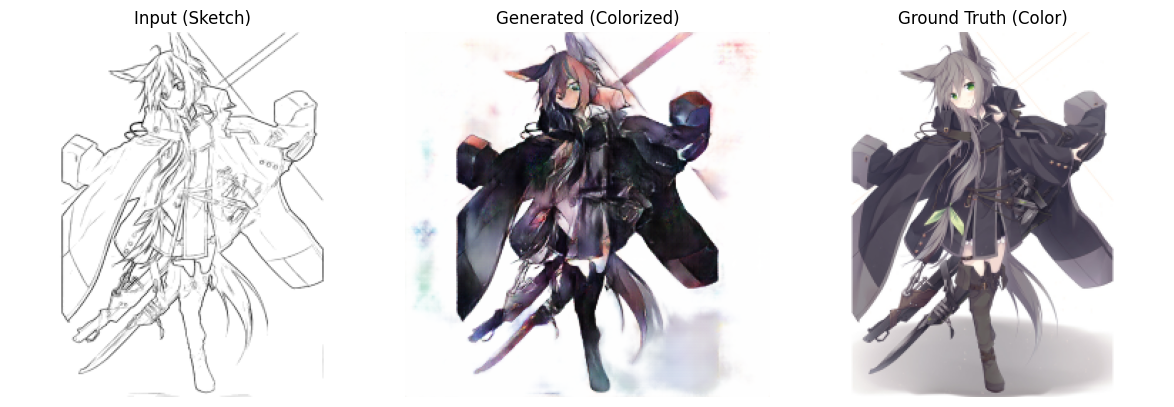

In [119]:
# Get one example from validation set
val_dataset = AnimeDataset(root_dir =config.VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
x, y = next(iter(val_loader))

x = x.to(config.DEVICE)
y = y.to(config.DEVICE)

new_gen.eval()
with torch.no_grad():
    y_fake = new_gen(x)

# Denormalize (reverse [-1, 1] to [0, 1])
def denormalize(tensor):
    return tensor * 0.5 + 0.5

# Plot the input, generated, and target images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input (Sketch)")
plt.imshow(denormalize(x[0]).permute(1, 2, 0).cpu().numpy())
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Generated (Colorized)")
plt.imshow(denormalize(y_fake[0]).permute(1, 2, 0).cpu().numpy())
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Ground Truth (Color)")
plt.imshow(denormalize(y[0]).permute(1, 2, 0).cpu().numpy())
plt.axis("off")

plt.tight_layout()
plt.show()
